In [2]:
import torch

## Notebook objectives
1. Create a train-val-test setup for consistent benchmarking
2. Experiment how weight initialization affects NN performance

# Define a linear regression model

In [ ]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

    def backward(self, loss):
        loss.backward()

In [12]:
input_dim = 10
output_dim = 1
n_samples = 25

# Creating a sample train, val and test dataset

In [50]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

# torch.random.manual_seed(42)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


# Run the forward pass

In [51]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []

clf = LinearRegression(input_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred - train_y)).sum()
    print(f" epoch: {i:3d} | loss: {loss: 3f}")

    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data


    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())

 epoch:   0 | loss:  634.138306
 epoch:   1 | loss:  614.310303
 epoch:   2 | loss:  576.527832
 epoch:   3 | loss:  524.345215
 epoch:   4 | loss:  462.634399
 epoch:   5 | loss:  397.088165
 epoch:   6 | loss:  333.647217
 epoch:   7 | loss:  277.909149
 epoch:   8 | loss:  234.584976
 epoch:   9 | loss:  207.058197
 epoch:  10 | loss:  197.091904
 epoch:  11 | loss:  204.711151
 epoch:  12 | loss:  228.268402
 epoch:  13 | loss:  264.679749
 epoch:  14 | loss:  309.800476
 epoch:  15 | loss:  358.895172
 epoch:  16 | loss:  407.147705
 epoch:  17 | loss:  450.153992
 epoch:  18 | loss:  484.345032
 epoch:  19 | loss:  507.296997


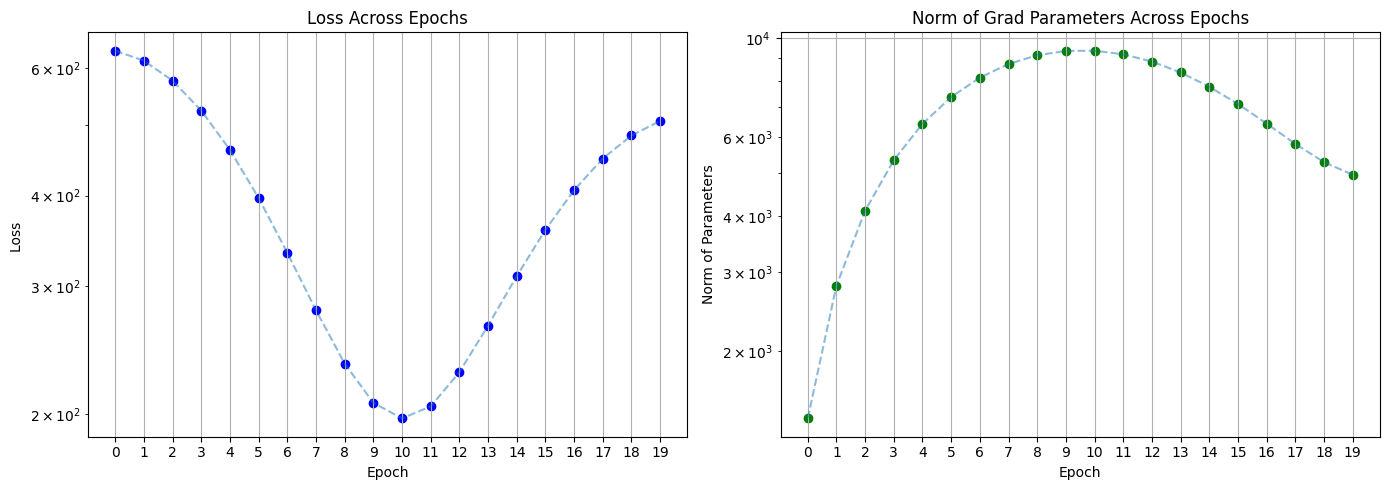

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0].scatter(epochs, losses, color='blue')
axes[0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss ')
axes[0].set_title('Loss Across Epochs')
axes[0].set_xticks(epochs)
axes[0].set_yscale('log')  # Set y-axis to log scale
axes[0].grid(True)

# Plot norms
axes[1].scatter(epochs, g_norms, color='green')
axes[1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Norm of Parameters')
axes[1].set_title('Norm of Grad Parameters Across Epochs')
axes[1].set_xticks(epochs)
axes[1].set_yscale('log')  # Set y-axis to log scale
axes[1].grid(True)

plt.tight_layout()
plt.show()

Let's add an evaluation setup to see performance on a validation set.

In [53]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

clf = LinearRegression(input_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred - train_y)).sum()

    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  542.437805 | val_loss:  484.014526
 epoch:   1 | train_loss:  528.924194 | val_loss:  468.601257
 epoch:   2 | train_loss:  502.943176 | val_loss:  446.687531
 epoch:   3 | train_loss:  466.502014 | val_loss:  419.621460
 epoch:   4 | train_loss:  422.404114 | val_loss:  389.042297
 epoch:   5 | train_loss:  374.020569 | val_loss:  356.762207
 epoch:   6 | train_loss:  325.016449 | val_loss:  324.635559
 epoch:   7 | train_loss:  279.054840 | val_loss:  294.428406
 epoch:   8 | train_loss:  239.504074 | val_loss:  267.696350
 epoch:   9 | train_loss:  209.172119 | val_loss:  245.681137
 epoch:  10 | train_loss:  190.090408 | val_loss:  229.233276
 epoch:  11 | train_loss:  183.364105 | val_loss:  218.766556
 epoch:  12 | train_loss:  189.100861 | val_loss:  214.246887
 epoch:  13 | train_loss:  206.422882 | val_loss:  215.215714
 epoch:  14 | train_loss:  233.559555 | val_loss:  220.845581
 epoch:  15 | train_loss:  268.012238 | val_loss:  230.022888
 epoch: 

In [36]:
losses, epochs

([562.8347778320312,
  547.755615234375,
  518.8545532226562,
  478.53253173828125,
  430.11700439453125,
  377.56451416015625,
  325.109375,
  276.8945617675781,
  236.61767578125,
  207.22637939453125,
  190.68893432617188,
  187.85952758789062,
  198.44735717773438,
  221.0877685546875,
  253.50454711914062,
  292.74371337890625,
  335.45355224609375,
  378.18182373046875,
  417.66302490234375,
  451.0687561035156],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

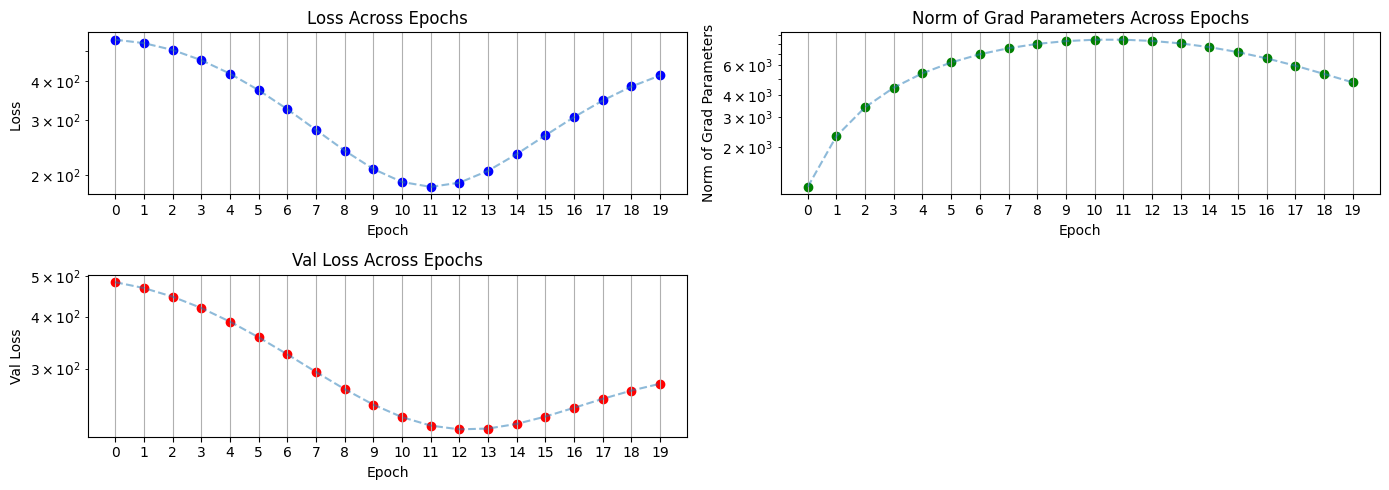

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

Both the train loss and val loss are coming down nicely. This is good!

We still don't see a steep drop in the loss. That's for another day to investigate.

What happens if we create multiple layers in our model?

# Define a neural net with multiple layers

In [64]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.linear2(self.linear1(x))

    def backward(self, loss):
        loss.backward()

In [65]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

# torch.random.manual_seed(42)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


In [66]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred - train_y)).sum()

    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  214.450317 | val_loss:  243.728607
 epoch:   1 | train_loss:  212.852859 | val_loss:  240.246857
 epoch:   2 | train_loss:  209.780350 | val_loss:  235.252747
 epoch:   3 | train_loss:  205.464874 | val_loss:  228.998779
 epoch:   4 | train_loss:  200.224182 | val_loss:  221.787842
 epoch:   5 | train_loss:  194.430145 | val_loss:  213.949951
 epoch:   6 | train_loss:  188.473358 | val_loss:  205.818359
 epoch:   7 | train_loss:  182.728485 | val_loss:  197.707672
 epoch:   8 | train_loss:  177.523621 | val_loss:  189.895706
 epoch:   9 | train_loss:  173.116760 | val_loss:  182.610260
 epoch:  10 | train_loss:  169.680817 | val_loss:  176.021484
 epoch:  11 | train_loss:  167.297394 | val_loss:  170.239288
 epoch:  12 | train_loss:  165.959320 | val_loss:  165.315796
 epoch:  13 | train_loss:  165.580200 | val_loss:  161.251968
 epoch:  14 | train_loss:  166.009705 | val_loss:  158.006775
 epoch:  15 | train_loss:  167.052765 | val_loss:  155.508682
 epoch: 

We see that the loss values are much better with a 2 layer neural net.

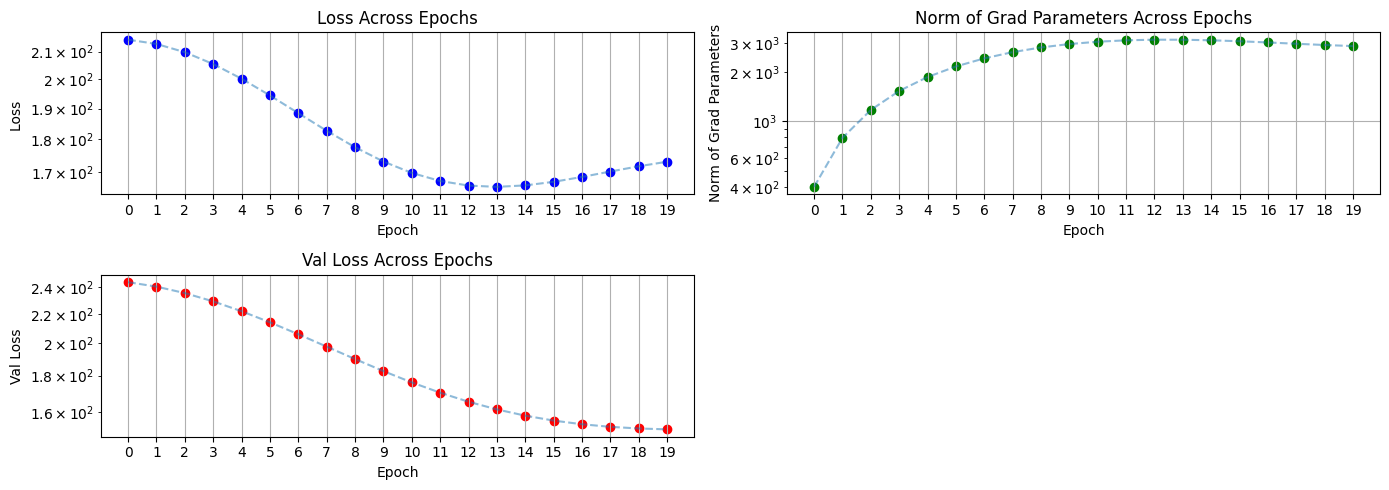

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

In [80]:
num_params = sum([param.numel() for param in clf.parameters()])
num_params

61

However, there is a bug in this code. We are superimposing a linear layer over another linear layer without a non-linearity. This is effectively a simple linear model. To make it more flexible, let's add a non-linearity.

In [93]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

    def backward(self, loss):
        loss.backward()

In [94]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

# torch.random.manual_seed(42)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


In [95]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred - train_y)).sum()

    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  333.158142 | val_loss:  330.243225
 epoch:   1 | train_loss:  326.083893 | val_loss:  317.965454
 epoch:   2 | train_loss:  312.621552 | val_loss:  300.993927
 epoch:   3 | train_loss:  294.063385 | val_loss:  280.863831
 epoch:   4 | train_loss:  272.160461 | val_loss:  259.395355
 epoch:   5 | train_loss:  248.931824 | val_loss:  238.420563
 epoch:   6 | train_loss:  226.429001 | val_loss:  219.734787
 epoch:   7 | train_loss:  206.561859 | val_loss:  204.864716
 epoch:   8 | train_loss:  191.048355 | val_loss:  194.883209
 epoch:   9 | train_loss:  181.042480 | val_loss:  190.376373
 epoch:  10 | train_loss:  177.228241 | val_loss:  191.467896
 epoch:  11 | train_loss:  179.648376 | val_loss:  197.680969
 epoch:  12 | train_loss:  187.893173 | val_loss:  208.052948
 epoch:  13 | train_loss:  200.936371 | val_loss:  221.208633
 epoch:  14 | train_loss:  217.264572 | val_loss:  235.512787
 epoch:  15 | train_loss:  235.060760 | val_loss:  249.243607
 epoch: 

We see that the loss values are much better with a 2 layer neural net.

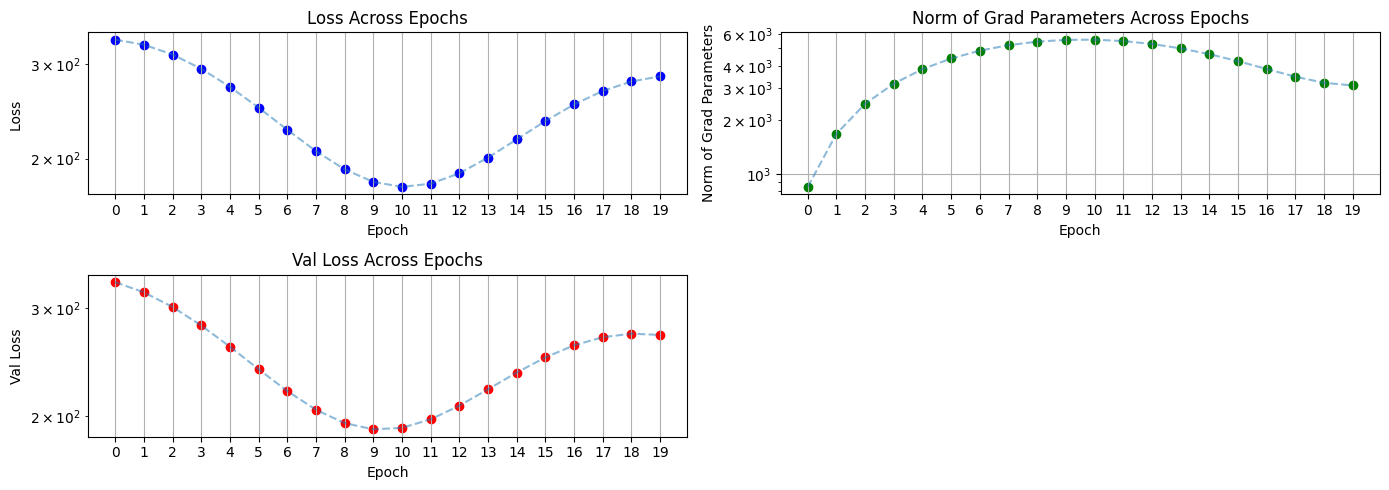

In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

The loss is not coming down. We gotta investigate why.